# Predicting First Acid Dissociation Constants for Molecules Using Graph Neural Networks

**Predicting acid dissociation constants (pKa)** is critical for various applications, from drug design to environmental chemistry. Traditional methods have limitations, prompting the exploration of novel approaches like *graph neural networks* (GNNs).

The project starts with a *dataset of 2439 molecules with known pKa values* sourced from IUPAC (International Union of Pure and Applied Chemistry). Each molecule is represented as a graph using its SMILES notation, encapsulating structural information. The model, a GNN tailored for graph data, learns from these molecular graphs and known pKa values to predict pKa accurately.

The objective is to develop a *scalable framework for pKa prediction*, beneficial for drug design, catalyst optimization, and environmental studies. By leveraging GNNs and comprehensive datasets, the aim is to expedite innovation in computational chemistry and related domains.

# Construct the dataset

The .csv file was reviewed to extract essential data: SMILES codes representing each molecule and their corresponding pK1 values. Emphasis was placed on selecting experimental data recorded within the temperature range of 20-25°C to ensure consistency. This streamlined dataset serves as the foundation for subsequent phases of model training and assessment.

In [1]:
import csv

initial_dataset = 'dataset_IUPAC.csv'
used_dataset = 'used_dataset.csv'

unique_strings = set()  # To store unique strings encountered in the first column

with open(initial_dataset, 'r', newline='') as f_input, open(used_dataset, 'w', newline='') as f_output:
    csv_reader = csv.reader(f_input)
    csv_writer = csv.writer(f_output)
    
    index = 1  # Index starts from 1
    
    for row in csv_reader:
        # Check if the third column contains "pK1" and the fifth column is a numerical value between 20 and 25
        if (
            len(row) >= 3 and row[2] == "pK1" and
            len(row) >= 5 and row[4].replace('.', '', 1).isdigit() and 20 <= float(row[4]) <= 25
        ):
            # Check if the string in the first column is unique
            if row[0] not in unique_strings:
                # Check if the fourth column does not contain unwanted strings
                unwanted_strings = ["~0.8", "~1.2", "<1.5", "<2", ">11", "4.40-4.80", "7.7-7.8", "ca. 3"]
                if all(val not in row[3] for val in unwanted_strings):
                    csv_writer.writerow([index, row[1], row[3]])  # Write index, second column, and forth column
                    unique_strings.add(row[0])
                    index += 1  # Increment index for the next row

**Pauling electronegativity**

Pauling electronegativity, named after Linus Pauling, measures how strongly an atom attracts electrons in a chemical bond. It's a scale from about 0.7 to 4.0, higher values indicating stronger attraction. Differences in electronegativity between atoms determine bond types and molecular polarity.

![alt text](Pauling_electronegativity.png)

In [2]:
from rdkit import Chem
import networkx as nx
import numpy as np

PAULING_ELECTRONEGATIVITY = {
    "C": 2.55,
    "Si": 1.90,
    "P": 2.19,
    "I": 2.66,
    "As": 2.18,
    "Cl": 3.16,
    "B": 2.04,
    "Se": 2.55,
    "S": 2.58,
    "Br": 2.96,
    "N": 3.04,
    "F": 3.98,
    "Ge": 2.01,
    "O": 3.44
}

class Molecule:
    def __init__(self, smiles, pk1):
        self.smiles = smiles
        self.graph, self.adj_matrix = self._generate_graph()
        self.pk1 = pk1
        self.num_node_features = 9
        self.num_bond_features = 5
    
    def _generate_graph(self):
        mol = Chem.MolFromSmiles(self.smiles)
        if mol is not None:
            G = nx.Graph()
            for atom in mol.GetAtoms():
                atom_attrs = {
                    "formal_charge": atom.GetFormalCharge(),
                    "num_implicit_hs": atom.GetNumImplicitHs(),
                    "is_aromatic": atom.GetIsAromatic(),
                    "mass": atom.GetMass(),
                    "degree": atom.GetDegree(),
                    "hybridization": atom.GetHybridization(),
                    "num_radical_electrons": atom.GetNumRadicalElectrons(),
                    "is_in_ring": atom.IsInRing(),
                    "pauling_electronegativity": self.get_pauling_electronegativity(atom.GetSymbol())
                }
                G.add_node(atom.GetIdx(), **atom_attrs)
            for bond in mol.GetBonds():
                bond_attrs = {
                    "bond_type": bond.GetBondTypeAsDouble(),
                    "is_conjugated": bond.GetIsConjugated(),
                    "is_aromatic": bond.GetIsAromatic(),
                    "stereo": bond.GetStereo(),
                    "is_in_ring": bond.IsInRing()
                }
                G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), **bond_attrs)
            adj_matrix = nx.adjacency_matrix(G).todense()
            adj_matrix = adj_matrix[:50, :50]  # Take only the first 50x50 submatrix
            adj_matrix = np.pad(adj_matrix, ((0, 50 - adj_matrix.shape[0]), (0, 50 - adj_matrix.shape[1])), mode='constant')
            return G, adj_matrix
        return None, None
    
    def get_pauling_electronegativity(self, symbol):
        return PAULING_ELECTRONEGATIVITY.get(symbol, None)

**Transformation from SMILES to molecule**

*Example:*

![alt text](SMILES_to_molecule.png)

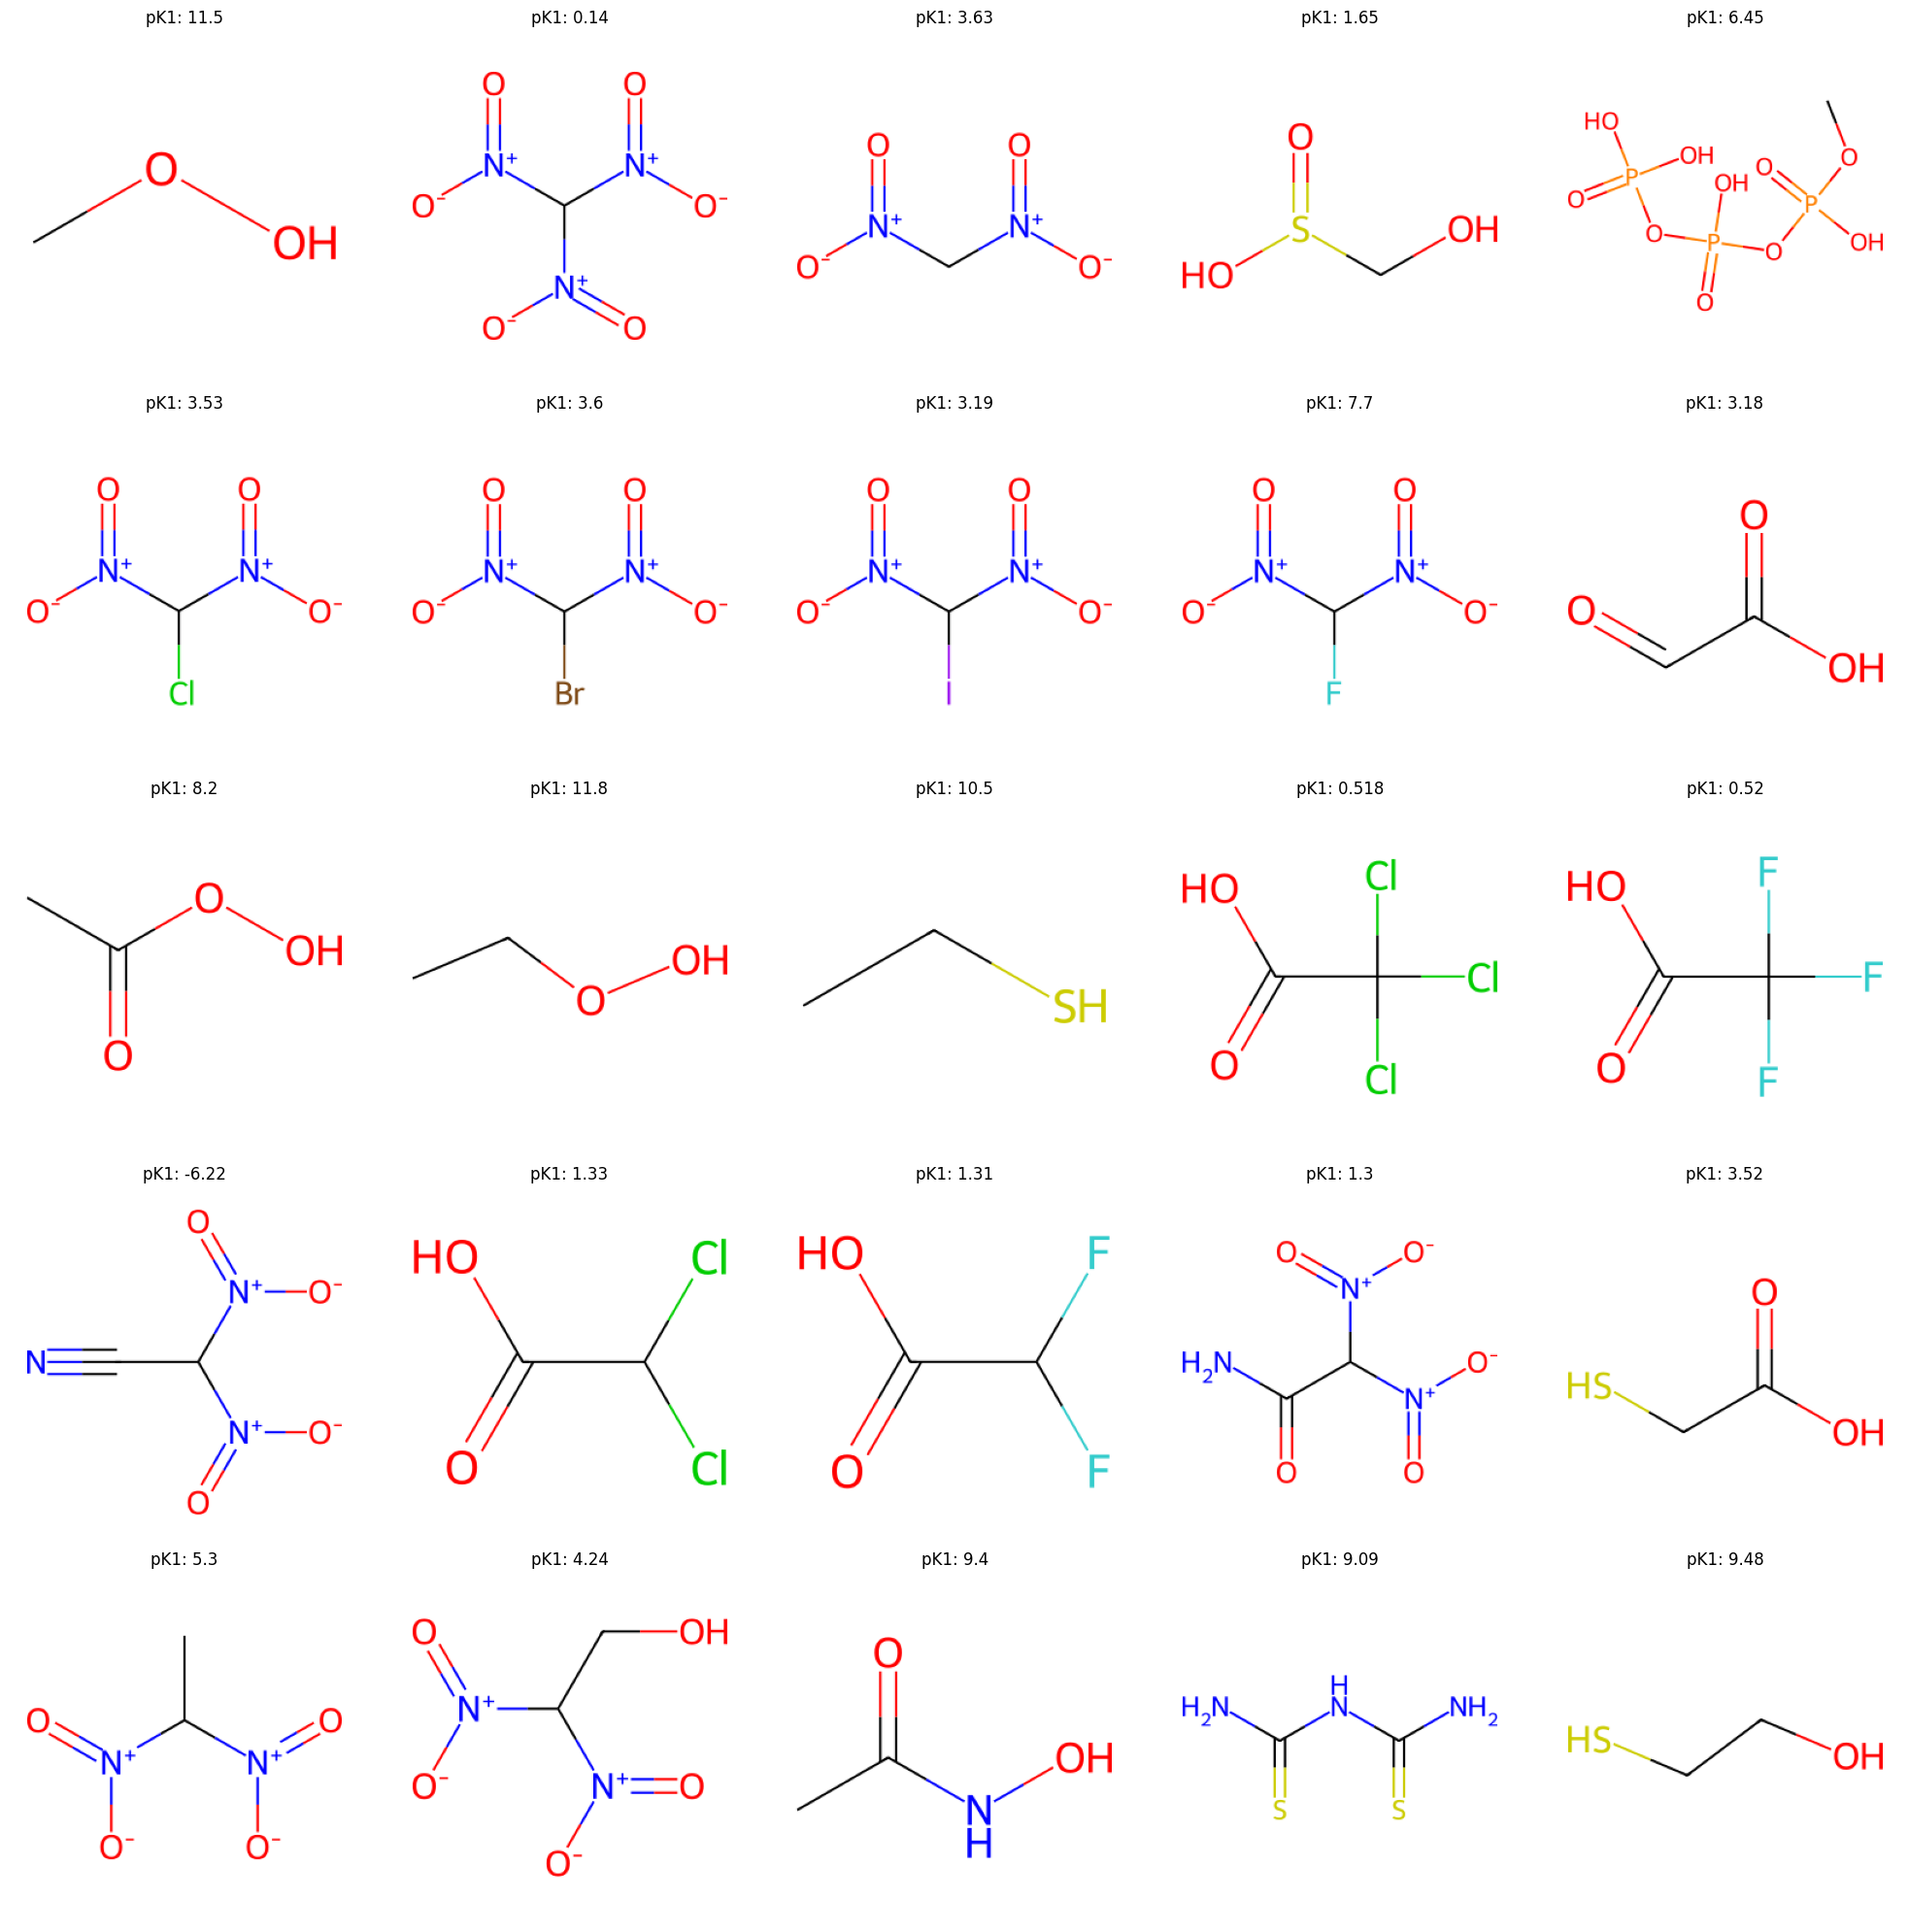

In [3]:
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
import csv

molecule_list = []

# Read data from the CSV file and populate molecule_list
with open(used_dataset, 'r', newline='') as f:
    csv_reader = csv.reader(f)
    for row in csv_reader:
        if len(row) >= 3:  # Assuming pK1 values are in the third column
            smiles = row[1]
            pk1 = float(row[2])  # Convert to float if necessary
            molecule = Molecule(smiles, pk1)
            molecule_list.append(molecule)

# Create subplots for each molecule
fig, axes = plt.subplots(5, 5, figsize=(20, 20))

# Iterate through the first 25 molecules in the molecule list and plot the structures
for idx, molecule in enumerate(molecule_list[:25]):
    row = idx // 5
    col = idx % 5
    ax = axes[row, col]

    # Convert SMILES string to RDKit molecule object
    mol = Chem.MolFromSmiles(molecule.smiles)
    
    # Draw the molecule image on the subplot
    img = Draw.MolToImage(mol)
    ax.imshow(img)
    ax.set_title(f"pK1: {molecule.pk1}")
    ax.axis('off')

plt.tight_layout()
plt.show()

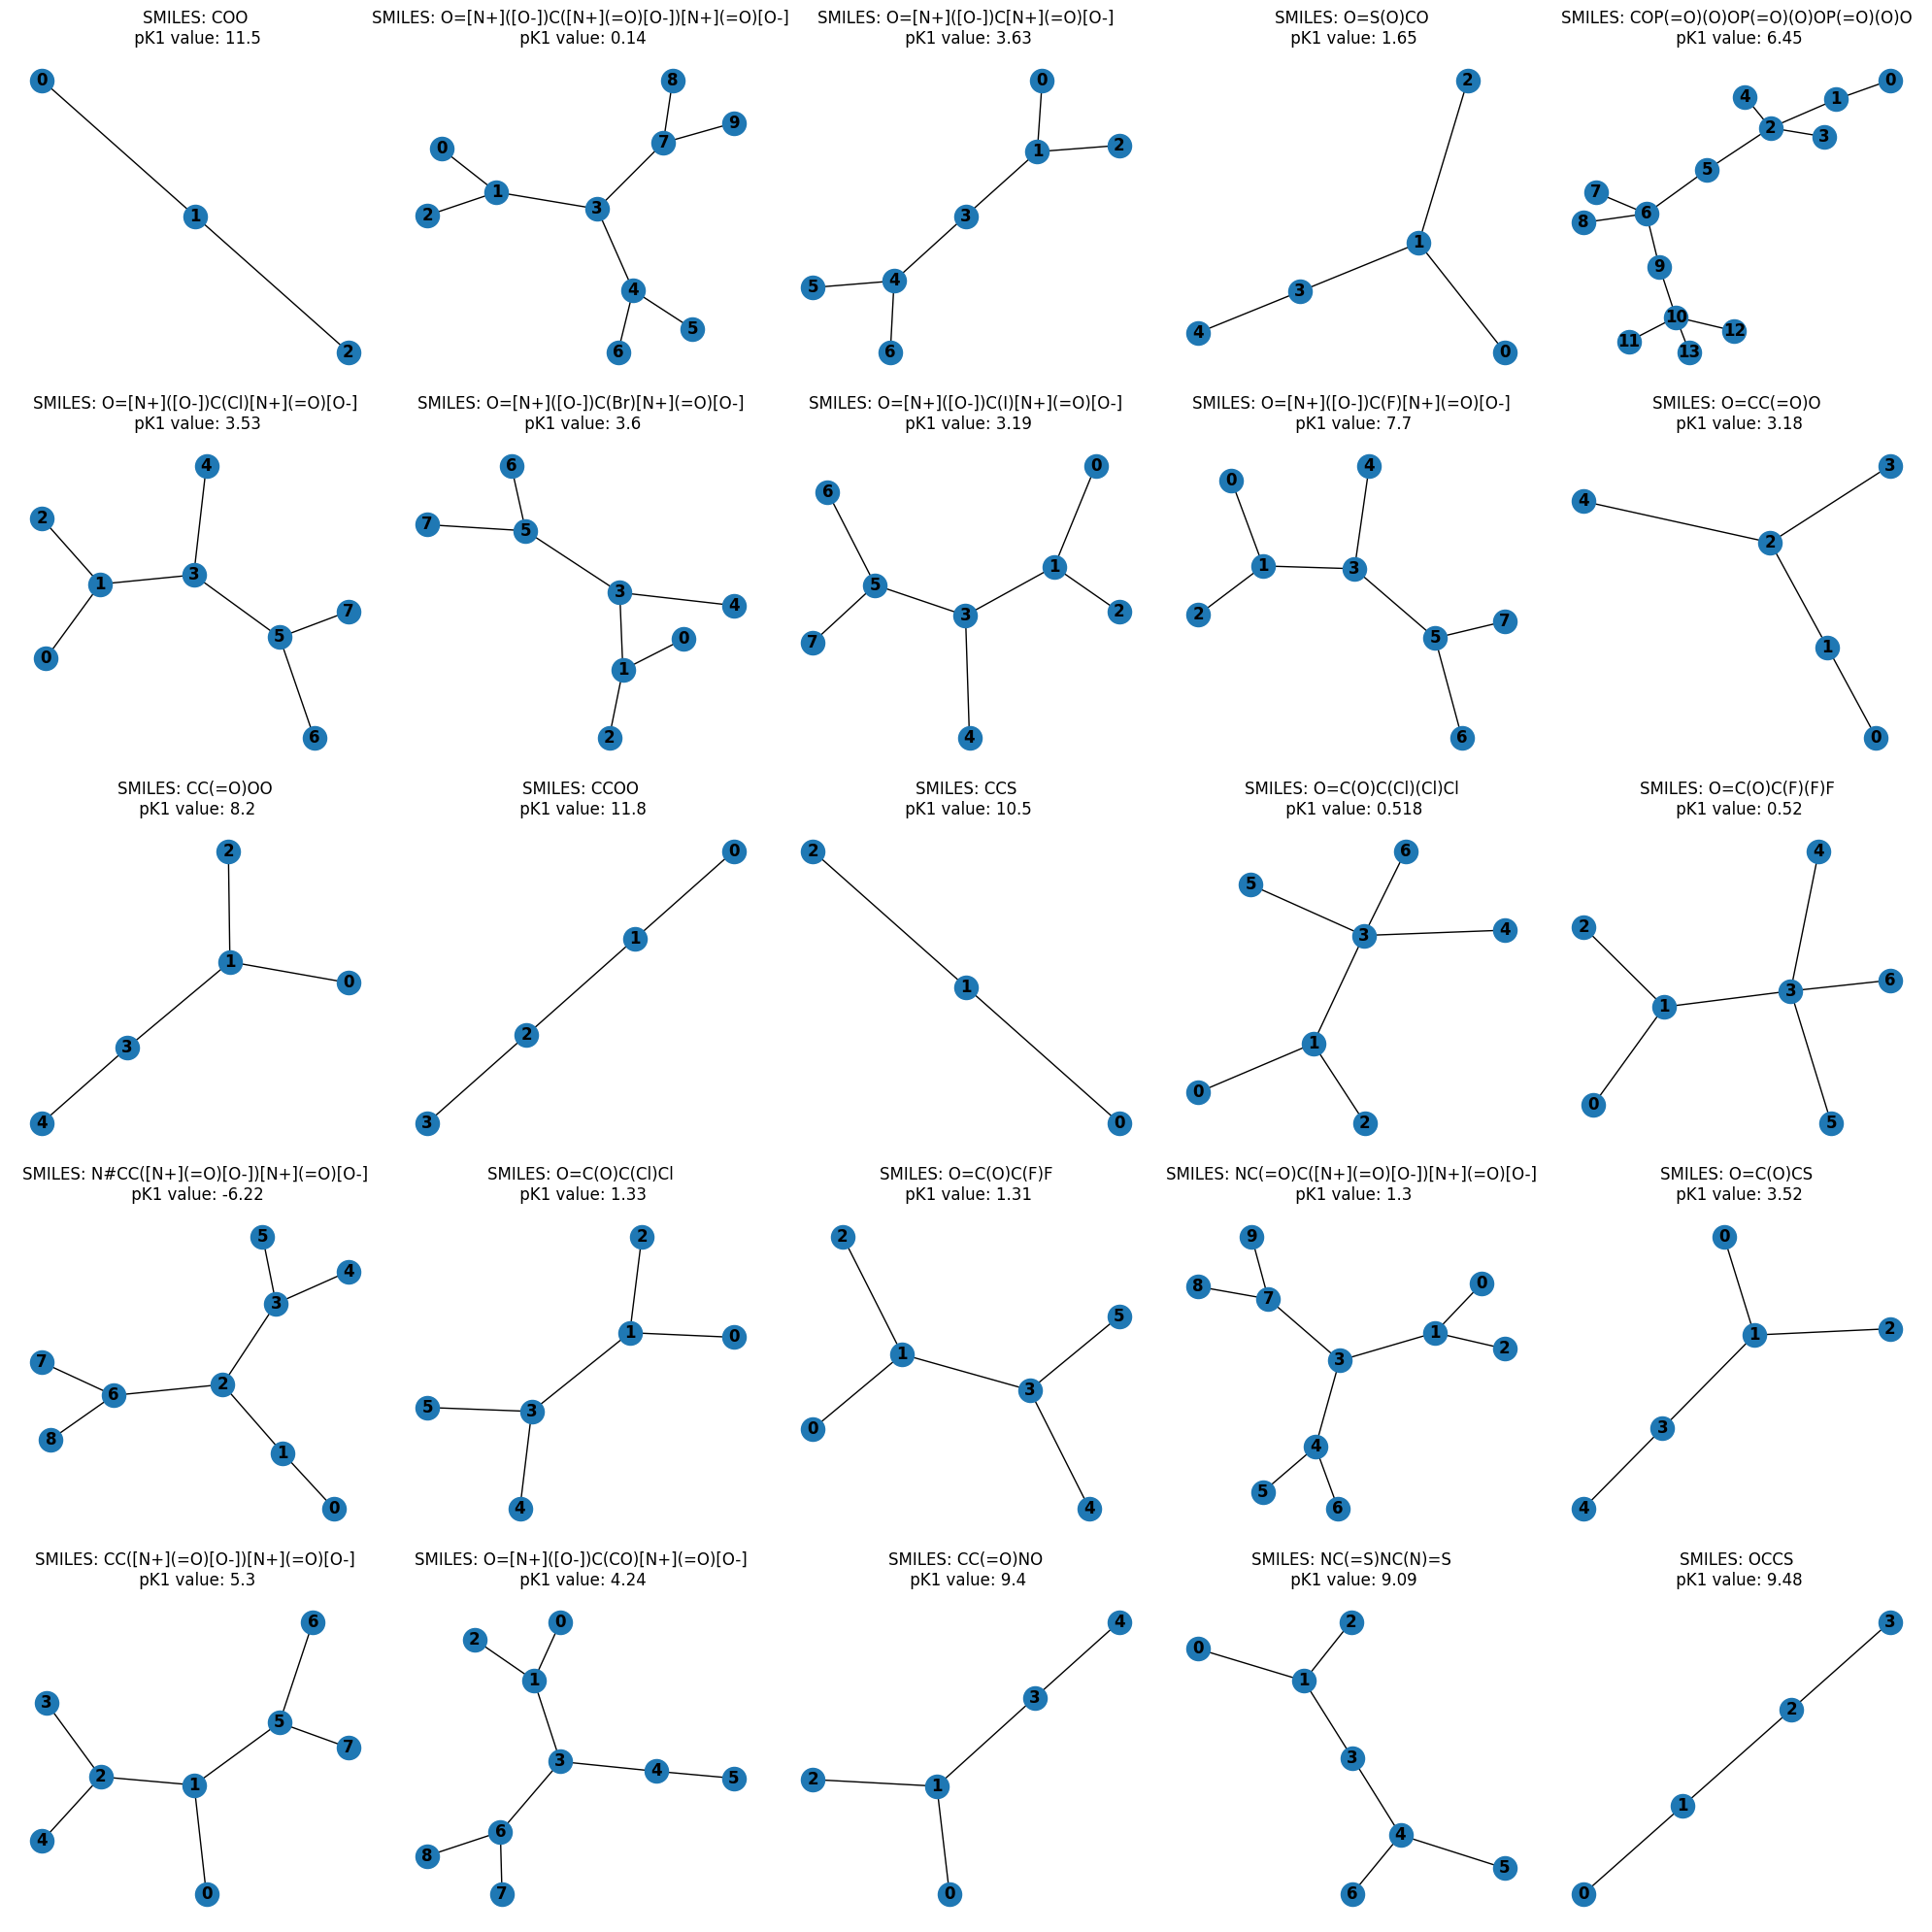

In [4]:
import matplotlib.pyplot as plt
import networkx as nx

# Create subplots for each molecule
fig, axes = plt.subplots(5, 5, figsize=(20, 20))

# Iterate through the first 25 molecules in the molecule list and plot the graphs
for idx, molecule in enumerate(molecule_list[:25]):
    row = idx // 5
    col = idx % 5
    ax = axes[row, col]
    ax.set_title(f"SMILES: {molecule.smiles}\n pK1 value: {molecule.pk1}")
    nx.draw(molecule.graph, ax=ax, with_labels=True, font_weight='bold')

plt.tight_layout()
plt.show()

In [5]:
max_atoms = 0
graph_with_max_atoms = None

for molecule in molecule_list:  # Assuming you have a list of instances of the Molecule class
    num_atoms = len(molecule.graph.nodes)
    if num_atoms > max_atoms:
        max_atoms = num_atoms
        graph_with_max_atoms = molecule.graph

print("Molecules with the most atoms has {} atoms.".format(max_atoms))


Molecules with the most atoms has 48 atoms.


# Creating the Graph Neural Network (GNN)

Developing a specialized neural network designed to predict the initial acid dissociation constant across diverse molecules is the focal point. Through the utilization of a comprehensive dataset comprising molecular graphs paired with their respective pK1 values, this chapter explores the intricate techniques involved in constructing and optimizing the neural network model.

In [7]:
import torch
from torch.utils.data import random_split, DataLoader
from torch_geometric.data import Data
from torch_geometric.data import Batch

class MoleculeDataset(torch.utils.data.Dataset):
    def __init__(self, molecules):
        self.molecules = molecules
    
    def __len__(self):
        return len(self.molecules)
    
    def __getitem__(self, idx):
        molecule = self.molecules[idx]
        graph = molecule.graph
        adj_matrix = molecule.adj_matrix
        # Convert networkx graph to PyTorch Geometric Data object
        x = []  # Node features
        edge_index = []  # Edge connectivity
        edge_attr = []  # Edge features
        y = molecule.pk1  # PK1 value
        
        for node_idx, attrs in graph.nodes(data=True):
            # Node features
            node_feats = [attrs["formal_charge"], attrs["num_implicit_hs"], attrs["is_aromatic"], attrs["mass"],
                          attrs["degree"], attrs["hybridization"], attrs["num_radical_electrons"], attrs["is_in_ring"], attrs["pauling_electronegativity"]]
            x.append(node_feats)
        
        for u, v, attrs in graph.edges(data=True):
            # Edge connectivity
            edge_index.append([u, v])
            # Edge features
            edge_feats = [attrs["bond_type"], attrs["is_conjugated"], attrs["is_aromatic"], attrs["stereo"], attrs["is_in_ring"]]
            edge_attr.append(edge_feats)
        
        x = torch.tensor(x, dtype=torch.float)
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        
        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=torch.tensor([y], dtype=torch.float), adj_matrix=torch.tensor(adj_matrix, dtype=torch.float))

# Assuming you have a list of Molecule objects called 'molecule_list'
dataset = MoleculeDataset(molecule_list)


# Split dataset into train, test, and validation sets (70%, 15%, 15%)
train_size = int(0.7 * len(dataset))
test_size = int(0.15 * len(dataset))
val_size = len(dataset) - train_size - test_size
train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

def custom_collate(batch):
    return Batch.from_data_list(batch)

# Create data loaders with custom collate function
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate)
validation_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate)

![alt text](gnn_model_graph.png)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import global_mean_pool, GCNConv
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout=0.35):
        super(GNNModel, self).__init__()

        # Node feature encoder
        self.node_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )

        # Convolutional layers
        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Final regression layer
        self.regression = nn.Linear(hidden_dim, output_dim)

        # Fitting parameters: weight matrices and bias vectors
        self.W1 = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.b1 = nn.Parameter(torch.randn(hidden_dim))
        self.W2 = nn.Parameter(torch.randn(hidden_dim, output_dim))
        self.b2 = nn.Parameter(torch.randn(output_dim))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Embed raw features
        x = self.node_encoder(x)

        for conv in self.convs:
            x = F.relu(conv(x, edge_index))
            x = self.dropout(x)

        # Global pooling
        x = global_mean_pool(x, batch)

        # Regression
        x = F.relu(torch.matmul(x, self.W1) + self.b1)
        out = torch.matmul(x, self.W2) + self.b2

        return out

# Assuming you have your dataset and DataLoader ready
train_loader, test_loader = DataLoader(train_dataset, batch_size=64), DataLoader(test_dataset, batch_size=64)

c:\Users\VIVOBOOK\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
c:\Users\VIVOBOOK\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/150, Train MAE: 4.9042, Val MAE: 2.6496, Val Loss: 9.7407
Epoch 2/150, Train MAE: 3.0716, Val MAE: 2.4239, Val Loss: 8.7188
Epoch 3/150, Train MAE: 2.7681, Val MAE: 2.3870, Val Loss: 9.6179
Epoch 4/150, Train MAE: 2.7114, Val MAE: 2.3423, Val Loss: 8.0687
Epoch 5/150, Train MAE: 2.6348, Val MAE: 2.3792, Val Loss: 8.3442
Epoch 6/150, Train MAE: 2.6063, Val MAE: 2.3001, Val Loss: 7.8521
Epoch 7/150, Train MAE: 2.5254, Val MAE: 2.3007, Val Loss: 8.0298
Epoch 8/150, Train MAE: 2.5294, Val MAE: 2.2829, Val Loss: 7.9844
Epoch 9/150, Train MAE: 2.4696, Val MAE: 2.2088, Val Loss: 7.6531
Epoch 10/150, Train MAE: 2.4760, Val MAE: 2.2324, Val Loss: 7.6772
Epoch 11/150, Train MAE: 2.4700, Val MAE: 2.2181, Val Loss: 7.6889
Epoch 12/150, Train MAE: 2.4786, Val MAE: 2.3253, Val Loss: 7.9470
Epoch 13/150, Train MAE: 2.4610, Val MAE: 2.1727, Val Loss: 7.5651
Epoch 14/150, Train MAE: 2.4442, Val MAE: 2.2240, Val Loss: 7.7383
Epoch 15/150, Train MAE: 2.4041, Val MAE: 2.1330, Val Loss: 7.3856
Epoc

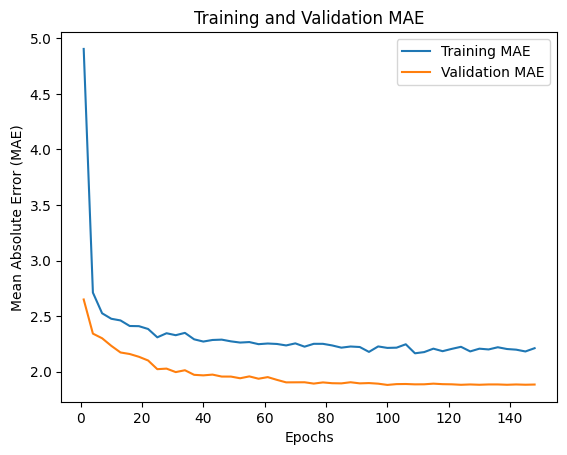

In [10]:
# Define your GNNModel
input_dim = molecule.num_node_features  # Assuming 9-dimensional input features
hidden_dim = 48
output_dim = 1  # Assuming single-dimensional regression output
num_layers = 2
model = GNNModel(input_dim, hidden_dim, output_dim, num_layers)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # You can choose another optimizer here

# Lists to store training and validation loss
train_losses = []
val_losses = []

# Training loop
num_epochs = 150
train_maes = []
val_maes = []

import torch.optim.lr_scheduler as lr_scheduler

# Define learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_predicted_values = []
    train_true_values = []
    for data in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        train_predicted_values.extend(outputs.squeeze().tolist())
        train_true_values.extend(data.y.squeeze().tolist())

        loss = criterion(outputs.squeeze(), data.y.float())  
        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()

    train_mae = np.mean(np.abs(np.array(train_predicted_values) - np.array(train_true_values)))
    train_maes.append(train_mae)

    # Validation
    model.eval()
    val_predicted_values = []
    val_true_values = []
    with torch.no_grad():
        val_loss = 0
        for data in test_loader:
            outputs = model(data)
            val_predicted_values.extend(outputs.squeeze().tolist())
            val_true_values.extend(data.y.squeeze().tolist())
            val_loss += criterion(outputs.squeeze(), data.y.float()).item()

    val_loss /= len(test_loader)
    val_mae = np.mean(np.abs(np.array(val_predicted_values) - np.array(val_true_values)))
    val_maes.append(val_mae)

    print(f"Epoch {epoch+1}/{num_epochs}, Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}, Val Loss: {val_loss:.4f}")

    # Learning rate scheduler step
    scheduler.step(val_loss)

# Plotting the MAE
plt.plot(range(1, len(train_maes) + 1, 3), train_maes[::3], label='Training MAE')  # Plot every 3th value
plt.plot(range(1, len(val_maes) + 1, 3), val_maes[::3], label='Validation MAE')  # Plot every 3th value
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

In [11]:
torch.save(model.state_dict(), "model.pth")

In [12]:
smallest_pk1 = float('inf')  # Initialize with positive infinity
largest_pk1 = float('-inf')   # Initialize with negative infinity

# Iterate over molecule_list to find smallest and largest pk1 values
for molecule in molecule_list:
    pk1 = molecule.pk1
    if pk1 is not None:  # Ensure pk1 is not None
        if pk1 < smallest_pk1:
            smallest_pk1 = pk1
        if pk1 > largest_pk1:
            largest_pk1 = pk1

print("In this dataset:")
print(" - Smallest pk1 value:", smallest_pk1)
print(" - Largest pk1 value:", largest_pk1)

In this dataset:
 - Smallest pk1 value: -6.22
 - Largest pk1 value: 19.2


In [13]:
from sklearn.metrics import r2_score

# Lists to store predicted and true values
predicted_values = []
true_values = []

# Evaluation loop using the test loader
model.eval()
with torch.no_grad():
    for data in test_loader:
        outputs = model(data)
        predicted_values.extend(outputs.squeeze().tolist())
        true_values.extend(data.y.squeeze().tolist())

# Convert lists to numpy arrays for easier manipulation if needed
predicted_values = np.array(predicted_values)
true_values = np.array(true_values)

# Calculate evaluation metrics or perform other analysis
# For example, you can calculate Mean Squared Error (MSE) or Mean Absolute Error (MAE)
mse = ((predicted_values - true_values) ** 2).mean()
mae = np.abs(predicted_values - true_values).mean()

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

# Calculate R²
r2 = r2_score(true_values, predicted_values)

print("R² Score:", r2)

Mean Squared Error (MSE): 6.454724913275619
Mean Absolute Error (MAE): 1.8837813933469254
R² Score: 0.3727244909150974


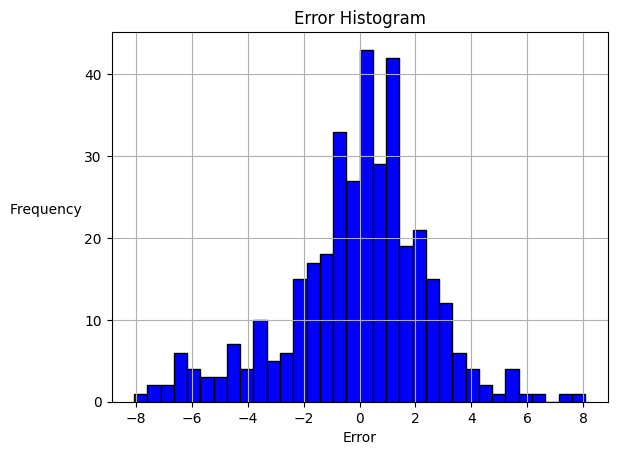

In [14]:
import matplotlib.pyplot as plt

# Calculate errors
errors = predicted_values - true_values

# Determine the range for the histogram
max_abs_error = max(abs(errors))
bin_range = (-max_abs_error, max_abs_error)

# Plot histogram
plt.hist(errors, bins=34, range=bin_range, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency               ', rotation = 0)
plt.title('Error Histogram')
plt.grid(True)
plt.show()

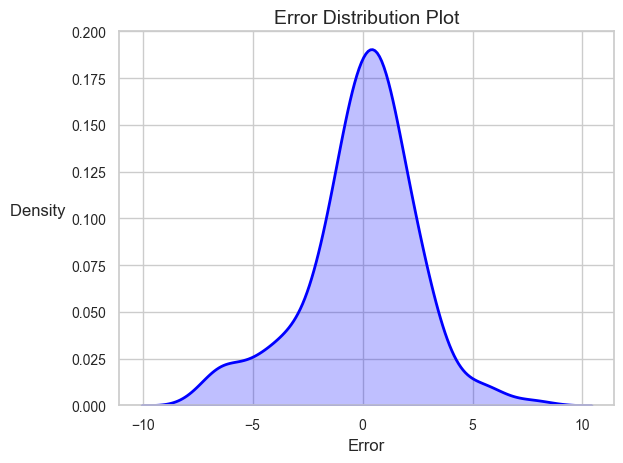

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_error_distribution(predicted_values, true_values):
    # Calculate errors
    errors = predicted_values - true_values
    
    # Set style
    sns.set(style="whitegrid")
    
    # Plot KDE plot
    sns.kdeplot(errors, color='blue', fill=True, linewidth=2)
    plt.xlabel('Error', fontsize=12)
    plt.ylabel('Density            ', fontsize=12, rotation = 0)
    plt.title('Error Distribution Plot', fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_error_distribution(predicted_values, true_values)


In [16]:
# Define tolerances
tolerances = [0.5, 1, 2, 3]
absolute_diff = np.abs(predicted_values - true_values)

# Calculate the percentage of predicted values within each tolerance
for tolerance in tolerances:
    # Count the number of predicted values that are within the tolerance of the true value
    close_count = np.sum(absolute_diff <= tolerance)
    # Calculate the percentage
    percentage_close = (close_count / len(predicted_values)) * 100
    # Print the result
    print(f"Percentage of predicted values within {tolerance}-unit tolerance of the true value: {percentage_close:.2f}%")


Percentage of predicted values within 0.5-unit tolerance of the true value: 20.55%
Percentage of predicted values within 1-unit tolerance of the true value: 37.26%
Percentage of predicted values within 2-unit tolerance of the true value: 64.38%
Percentage of predicted values within 3-unit tolerance of the true value: 80.00%


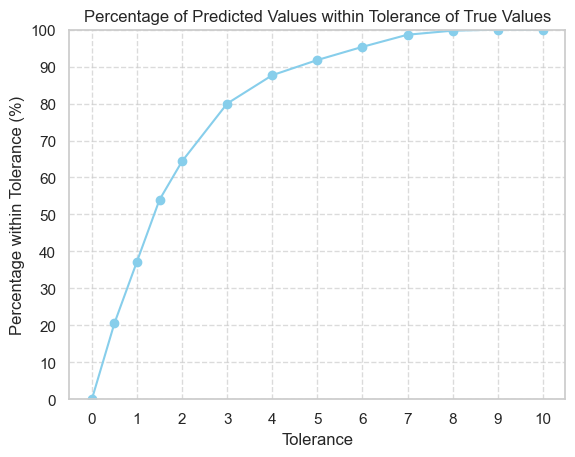

In [17]:
import matplotlib.pyplot as plt

# Define maximum tolerance level
max_tolerance = 10

# Define tolerances from 1 to max_tolerance
tolerances = [0, 0.5, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Initialize lists to store percentage of predicted values within each tolerance
percentages = []

# Calculate the percentage of predicted values within each tolerance
for tolerance in tolerances:
    # Count the number of predicted values that are within the tolerance of the true value
    close_count = np.sum(absolute_diff <= tolerance)
    # Calculate the percentage
    percentage_close = (close_count / len(predicted_values)) * 100
    # Append the percentage to the list
    percentages.append(percentage_close)

# Plot the line chart
plt.plot(tolerances, percentages, marker='o', color='skyblue')
plt.xlabel('Tolerance')
plt.ylabel('Percentage within Tolerance (%)')
plt.title('Percentage of Predicted Values within Tolerance of True Values')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(ticks=range(0, 11))
plt.yticks(ticks=range(0, 101, 10))
plt.ylim(0, 100)  # Set y-axis limit to ensure percentages are between 0 and 100
plt.show()
